In [12]:
import json
import os
import pandas as pd
import re
import time

# read the current path, set to mypath
mypath = os.getcwd()
myfile = r"CMG_Processing_MSDManual.xlsx"
process_knowledge_filename = r"CMG_Prompts.xlsx"

# Use os.path.join to create the full paths
process_knowledge_file_fullpath = os.path.join(mypath, process_knowledge_filename.lstrip('/'))
myexcelfile = os.path.join(mypath, myfile.lstrip('/'))

In [26]:
# print content of CMG_Prompts.xlsx
df = pd.read_excel(process_knowledge_file_fullpath)
# print the full content of the row
print(df.loc[df['knowledge_area'] == "step1_group_paragraphs"]['knowledge'].values[0])
print(df.loc[df['knowledge_area'] == "step2_extract_events"]['knowledge'].values[0])

Let's work this out in a step by step way to be sure we have the right answer.
<instruction>
Coherently split/breakdown this document into meaningful paragraphs. Keep metadata into a separated part.
A document have a list of labels that: summarize the key areas covered in the article.
Each paragraph can have a few labels. Labels represent the category and key info of the article.
A document has Key points. Keep Key points into a separated part.
</instruction>
<format>
Paragraphs should maintain natural language form.
All labels are in a list. 
Labels should have full meaning, because each paragraph will be processed independently. For example, clinic observation is not a good label; 'Acute kidney injury clinic observation' is a clear label. 
Give json as the output, in this structure {"article_label": [***,***], "article_metadata": {metadata of the article}, "article_keypoint": [key points of the article], "paragraphs": [{"label": [***,***], "new_paragraph": ***},{"label": [***,***], "

In [29]:
with pd.ExcelFile(myexcelfile) as xls:
    # Iterate through all sheets
    for sheet_name in xls.sheet_names:
        # Read each sheet
        df = pd.read_excel(xls, sheet_name)

        # Print the sheet name and its columns
        print(f"Sheet name: {sheet_name}")
        print("Columns:", df.columns.tolist())

Sheet name: paragraphs
Columns: ['ID', 'Paragraph text', 'Article ID', 'url', 'processed', 'paragraph labels', 'Convert paragraph to events', 'processing user', 'processing date', 'comments', 'article labels']
Sheet name: sentences
Columns: ['Event ID', 'Paragraph ID', 'Article ID', 'Head labels', 'Relation label', 'Tail labels', 'Head text', 'Relation text', 'Tail text', 'Sentence text']
Sheet name: articles
Columns: ['Article ID', 'Full text', 'url', 'article metadata', 'article keypoint', 'article labels', 'processed', 'json str', 'processing user', 'processing date', 'comments']


In [30]:
# load the content of 'sentences' sheet to a dataframe
df_sentences = pd.read_excel(myexcelfile, sheet_name='sentences')
df_sentences.head()

,Event ID,Paragraph ID,Article ID,Head labels,Relation label,Tail labels,Head text,Relation text,Tail text,Sentence text
0,1,1,1,"treatment, diagnostic procedure",AND,"condition, diagnostic procedure",Flexible endoscopes equipped with video cameras,can be used to view,the upper gastrointestinal tract from pharynx ...,Flexible endoscopes equipped with video camera...
1,2,1,1,"treatment, diagnostic procedure",AND,"condition, diagnostic procedure","specialized, longer enteroscopes",can be used to assess,the deeper parts of the jejunum and ileum,"specialized, longer enteroscopes can be used t..."
2,3,1,1,"treatment, diagnostic procedure",AND,"treatment, diagnostic procedure",endoscopy,can combine,diagnosis and therapy in one procedure,endoscopy can combine diagnosis and therapy in...
3,4,1,1,"treatment, diagnostic procedure",IMPLIES,advantage,endoscopy,gives,a significant advantage over studies that prov...,endoscopy gives a significant advantage over s...
4,5,1,1,"treatment, diagnostic procedure",NEGATES,disadvantage,endoscopy,often outweighs,higher cost and need for sedation,endoscopy often outweighs higher cost and need...


In [31]:
# check number of rows and columns
print(df_sentences.shape)

(998, 10)


In [33]:
# find all unique values in the 'Relation label' column
print(df_sentences['Relation label'].unique())
print(df_sentences['Relation label'].value_counts())

['AND' 'IMPLIES' 'NEGATES' 'CAUSES' 'THRESHOLD' 'USES' 'ENABLES'
 'CONTRAINDICATES' 'SAFE_WITH' 'REQUIRES_STOP' 'INTERACTS_WITH' 'REQUIRES'
 'INCLUDES' 'VARIES' 'IMPROVES' 'OR' 'DIAGNOSED BY' 'INCREASES'
 'DELIVERED_VIA' 'REFRACTORY_TO' 'DIRECTS' 'LIMITS' 'TREATED WITH'
 'RARELY' 'SPECIFIC_FOR' 'TREATED_BY' 'PREFERRED_BY' 'DIAGNOSED_BY'
 'TREATED_WITH' 'PROGRESSES TO' 'MAY DEVELOP INTO' 'LEADS TO' 'RESULTS IN'
 'CAN LEAD TO' 'RELIEVED_BY' 'SAFE_EXCEPT' 'PROGRESSES_TO' 'HELPS_PREVENT'
 'AVOIDED_IN' 'EMPHASIZED' 'CHARACTERIZED_BY' 'SUGGESTS' 'DECREASES'
 'DEPEND ON' 'RISK FACTOR' 'COMPLICATION' 'DIFFERENT' 'TREATED BY'
 'DEVELOPS_FROM' 'DEFINITION' 'STANDARD' 'REPLACES' 'ALTERNATIVE_TO'
 'CONFIRMS' 'DIFFICULT' 'CONTRASTS' 'SHOULD BE OBTAINED IN' 'REVEALS'
 'SHOULD BE TESTED FOR' 'TREATMENT' 'ASSOCIATED_WITH' 'TEMPORAL'
 'DETERMINES' 'EFFECTIVE FOR']
Relation label
CAUSES           371
IMPLIES          339
THRESHOLD         58
NEGATES           52
AND               37
                ... 

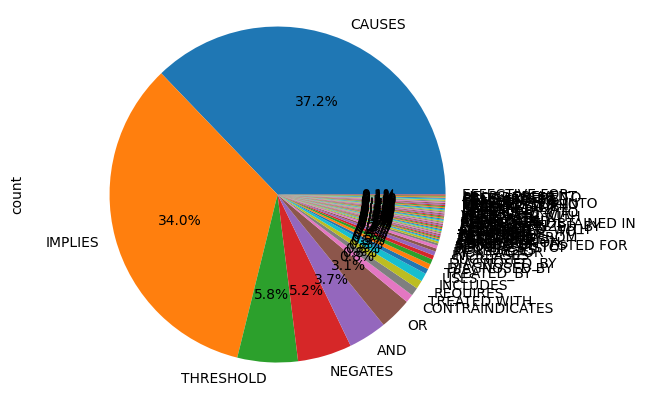

In [35]:
# Display Relation label value counts in a pie chart using matplotlib
import matplotlib.pyplot as plt

df_sentences['Relation label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [52]:
# Define the mapping for the groups
label_groups = {
    'IMPLIES': ['IMPLIES', 'ENABLES', 'IMPROVES', 'RESULTS_IN', 'LEADS_TO', 'MAY_DEVELOP_INTO', 'PROGRESSES_TO', 'SUGGESTS', 'VARIES', 'DEPEND ON', 'INCLUDES', 'DETERMINES'],
    'CAUSES': ['CAUSES', 'CAN_LEAD_TO', 'DEVELOPS_FROM', 'HELPS_PREVENT', 'RISK_FACTOR', 'COMPLICATION', 'PROGRESSES TO', 'INCREASES', 'LEADS_TO', 'RESULTS_IN', 'IMPROVES'],
    'NEGATES': ['NEGATES', 'CONTRAINDICATES', 'SAFE_WITH', 'REQUIRES_STOP', 'AVOIDED_IN', 'RARELY', 'SAFE_EXCEPT', 'REFRACTORY_TO', 'DIFFICULT', 'DECREASES'],
    'AND': ['AND', 'DEPEND_ON', 'DIAGNOSED_BY', 'ASSOCIATED_WITH', 'CHARACTERIZED_BY', 'STANDARD'],
    'OR': ['OR', 'ALTERNATIVE_TO', 'PREFERRED_BY', 'STANDARD'],
    'THRESHOLD': ['THRESHOLD', 'REQUIRES', 'REQUIRES_STOP', 'TEMPORAL'],
    'TREATMENT': ['TREATED_WITH', 'TREATED_BY', 'RELIEVED_BY', 'EFFECTIVE_FOR'],
    'DIAGNOSIS/DETECTION': ['DIAGNOSED_BY', 'SUGGESTS', 'CONFIRMS', 'REVEALS', 'SHOULD_BE_TESTED_FOR'],
    'RECOMMENDATION': ['SHOULD_BE_OBTAINED_IN', 'SHOULD_BE_TESTED_FOR'],
    'CLASSIFICATION': ['DEFINITION', 'CHARACTERIZED_BY', 'REPLACES', 'ALTERNATIVE_TO']
}




In [53]:
# Reverse the mapping to allow lookup of the group by label
group_lookup = {label: group for group, labels in label_groups.items() for label in labels}
# Function to map each cell to its group
def map_to_group(label):
    # strip leading and trailing whitespace
    label = label.strip()
    label = label.upper()
    # replace " " with "_"
    label = re.sub(r'\s+', '_', label)
    return group_lookup.get(label, label)

In [54]:
group_lookup

{'IMPLIES': 'IMPLIES',
 'ENABLES': 'IMPLIES',
 'IMPROVES': 'CAUSES',
 'RESULTS_IN': 'CAUSES',
 'LEADS_TO': 'CAUSES',
 'MAY_DEVELOP_INTO': 'IMPLIES',
 'PROGRESSES_TO': 'IMPLIES',
 'SUGGESTS': 'DIAGNOSIS/DETECTION',
 'VARIES': 'IMPLIES',
 'DEPEND ON': 'IMPLIES',
 'INCLUDES': 'IMPLIES',
 'DETERMINES': 'IMPLIES',
 'CAUSES': 'CAUSES',
 'CAN_LEAD_TO': 'CAUSES',
 'DEVELOPS_FROM': 'CAUSES',
 'HELPS_PREVENT': 'CAUSES',
 'RISK_FACTOR': 'CAUSES',
 'COMPLICATION': 'CAUSES',
 'PROGRESSES TO': 'CAUSES',
 'INCREASES': 'CAUSES',
 'NEGATES': 'NEGATES',
 'CONTRAINDICATES': 'NEGATES',
 'SAFE_WITH': 'NEGATES',
 'REQUIRES_STOP': 'THRESHOLD',
 'AVOIDED_IN': 'NEGATES',
 'RARELY': 'NEGATES',
 'SAFE_EXCEPT': 'NEGATES',
 'REFRACTORY_TO': 'NEGATES',
 'DIFFICULT': 'NEGATES',
 'DECREASES': 'NEGATES',
 'AND': 'AND',
 'DEPEND_ON': 'AND',
 'DIAGNOSED_BY': 'RECOMMENDATION',
 'ASSOCIATED_WITH': 'AND',
 'CHARACTERIZED_BY': 'CLASSIFICATION',
 'STANDARD': 'OR',
 'OR': 'OR',
 'ALTERNATIVE_TO': 'CLASSIFICATION',
 'PREFERRED

In [55]:
# Read the Excel file
output_file = 'CMG_EDA.xlsx'  # Output file name

# Apply the mapping function to label_groups

# Apply the mapping function to the entire column
df_sentences['Group_relation_label'] = df_sentences['Relation label'].apply(map_to_group)

# Save the modified DataFrame back to an Excel file
df_sentences.to_excel(output_file, index=False, engine='openpyxl')

print(f"Labels categorized and saved to {output_file}")

Labels categorized and saved to CMG_EDA.xlsx


In [56]:
# find all unique values in the 'Relation label' column
print(df_sentences['Group_relation_label'].unique())
print(df_sentences['Group_relation_label'].value_counts())

['AND' 'IMPLIES' 'NEGATES' 'CAUSES' 'THRESHOLD' 'USES' 'INTERACTS_WITH'
 'OR' 'RECOMMENDATION' 'DELIVERED_VIA' 'DIRECTS' 'LIMITS' 'TREATMENT'
 'SPECIFIC_FOR' 'EMPHASIZED' 'CLASSIFICATION' 'DIAGNOSIS/DETECTION'
 'DIFFERENT' 'CONTRASTS']
Group_relation_label
CAUSES                 384
IMPLIES                353
THRESHOLD               69
NEGATES                 68
AND                     39
OR                      33
TREATMENT               18
RECOMMENDATION          11
DIAGNOSIS/DETECTION      6
USES                     5
CLASSIFICATION           4
EMPHASIZED               1
DIFFERENT                1
DELIVERED_VIA            1
SPECIFIC_FOR             1
LIMITS                   1
DIRECTS                  1
INTERACTS_WITH           1
CONTRASTS                1
Name: count, dtype: int64


: 

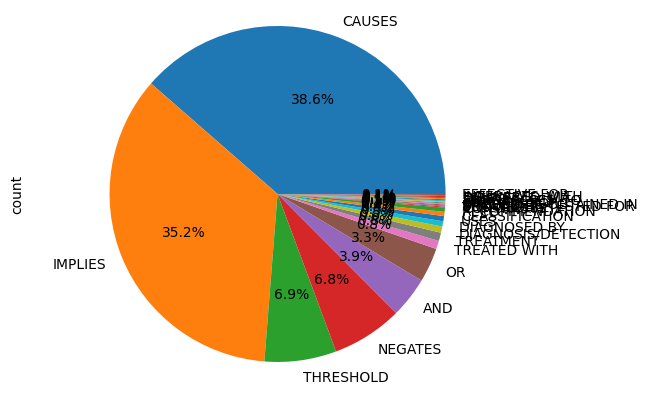

In [47]:
# Display Relation label value counts in a pie chart using matplotlib
import matplotlib.pyplot as plt

df_sentences['Group_relation_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()